# Wildfire Smoke Impact on Hartford Real Estate Market

## Project Overview
In an era of increasing environmental challenges, the intersection of climate-related events and urban economic systems presents a critical area of research. This analysis explores the nuanced relationship between wildfire smoke exposure and real estate market dynamics in Hartford, Connecticut, using a comprehensive, interdisciplinary approach to understanding environmental impacts on property values.

## Research Questions
The study seeks to address several key investigative questions:

- How do wildfire smoke events correlate with local real estate market trends?
- Can we quantify the potential economic impact of environmental hazards on property valuations?
- What is the relationship between air quality metrics and property sale amounts?

## Methodology
This approach integrates multiple data sources to create a holistic view:

- Real estate transaction records from Hartford
- Detailed wildfire data
- Air Quality Index (AQI) indices

By leveraging advanced statistical techniques, including time series analysis, regression modeling, and sophisticated data preprocessing, I aim to:

- Extract meaningful patterns from complex, multi-dimensional data
- Develop predictive models that capture the subtle interactions between environmental events and real estate markets
- Provide insights that could be valuable for urban planners, real estate professionals, and policymakers

## Significance
This research contributes to our understanding of how environmental phenomena—specifically wildfire smoke—might influence local real estate ecosystems. As climate change continues to reshape environmental conditions, such analyses become increasingly important for understanding urban economic resilience and adaptation strategies.

**Disclaimer: While this analysis provides valuable insights, it represents a specific case study and should be interpreted with appropriate contextual nuance.**

In [6]:
# import relevant libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

### Step 1: Data Preprocessing and Feature Engineering

In this first step, I load the three datasets that will form the foundation of my analysis. First, I convert the date columns to standardized datetime format I also merged all of these datasets together. Then I merge them all together based on their dates. Then I begin the aggregation and feature engineering process. 

Here's what I did ... 
- **Create annual aggregations of real estate transactions**
- **Recreate the 'smoke impact' estimate that considers:**
    - Fire size
    - Duration of burning
    - Distance from the area
- **Agregate the air quality data annually**
- **Create lagged variables to capture:**
    - Previous year's smoke impact
    - Three-year historical smoke impact
    - Previous year's maximum AQI
- **Remove extreme values that could skew statistical models**

Final Dataset output: `enhanced_data`

This data is the merged dataset with all of our cleaned data (wildfire, AQI, and real estate) ready to be put through a regression and forecasting model!

In [211]:
# Load datasets
real_estate_df = pd.read_csv('filtered_real_estate_df.csv')
wildfire_df = pd.read_csv('selected_processed_wildfires2.csv')
aqi_data = pd.read_csv('aqi_data.csv')

/var/folders/kp/42tvxzv924xdtdyzydmjjp380000gn/T/ipykernel_7160/2748658718.py:2: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate_df = pd.read_csv('filtered_real_estate_df.csv')


In [3]:
# Preprocess and merge datasets
hartford_real_estate = real_estate_df

# Extract year from 'Date Recorded'
hartford_real_estate['year'] = pd.to_datetime(hartford_real_estate['Date Recorded'], errors='coerce').dt.year

In [4]:
# Aggregate real estate data by year
hartford_annual = hartford_real_estate.groupby('year').agg(
    median_sale_amount=('Sale Amount', 'median'),
    median_assessed_value=('Assessed Value', 'median'),
    count_sales=('Sale Amount', 'count')
).reset_index()

# Merge wildfire data and AQI data
wildfire_df['smoke_impact'] = wildfire_df['fire_size_acres'] * wildfire_df['days_burning'] * (1 / wildfire_df['average_distance_miles'])
cumulative_smoke_impact = wildfire_df.groupby('year')['smoke_impact'].sum().reset_index()

aqi_data['year'] = pd.to_datetime(aqi_data['date']).dt.year
annual_aqi = aqi_data.groupby('year').agg(
    avg_daily_max_aqi=('daily_max_aqi', 'mean'),
    max_daily_aqi=('daily_max_aqi', 'max')
).reset_index()

In [5]:
# merging hartford real estate data, with aqi and wildfire dataset
enhanced_data = pd.merge(hartford_annual, cumulative_smoke_impact, on='year', how='inner')
enhanced_data = pd.merge(enhanced_data, annual_aqi, on='year', how='inner')

In [10]:
# Add lagged variables
enhanced_data = enhanced_data.sort_values('year')
enhanced_data['smoke_impact_lag_1'] = enhanced_data['smoke_impact'].shift(1)
enhanced_data['smoke_impact_lag_3'] = enhanced_data['smoke_impact'].shift(3)
enhanced_data['max_daily_aqi_lag_1'] = enhanced_data['max_daily_aqi'].shift(1)
enhanced_data['max_daily_aqi_aqi_lag_3'] = enhanced_data['max_daily_aqi'].shift(3)
enhanced_data['transaction_volume'] = enhanced_data['count_sales']
enhanced_data['transaction_volume_lag'] = enhanced_data['transaction_volume'].shift(1)

In [7]:
# Outlier removal using IQR
def remove_outliers(df, column):
    """Function to remove outliers based on IQR 
    
    Returns: a dataframe with outliers removed """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from target and key predictors
columns_to_clean = ['median_sale_amount', 'smoke_impact', 'transaction_volume']
cleaned_data = enhanced_data.copy()
for col in columns_to_clean:
    cleaned_data = remove_outliers(cleaned_data, col)

# Log-transform 'smoke_impact' to reduce skewness (might not use..)
cleaned_data['log_smoke_impact'] = np.log1p(cleaned_data['smoke_impact'])


In [114]:
enhanced_data = enhanced_data.rename(columns={'max_daily_aqi_aqi_lag_3': 'max_daily_aqi_lag_3'})

In [118]:
enhanced_data

,year,median_sale_amount,median_assessed_value,count_sales,smoke_impact,avg_daily_max_aqi,max_daily_aqi,smoke_impact_lag_1,smoke_impact_lag_3,max_daily_aqi_lag_1,max_daily_aqi_lag_3,transaction_volume,transaction_volume_lag
0,2001,159900.0,90000.0,2657,322.566369,52.391781,192,322.566369,322.566369,192.0,192.0,2657,2657.0
1,2002,172000.0,90340.0,11240,1360.951995,51.265753,187,322.566369,322.566369,192.0,192.0,11240,2657.0
2,2003,193000.0,96115.0,11440,1.866735,51.339726,130,1360.951995,322.566369,187.0,192.0,11440,11240.0
3,2004,219900.0,103000.0,15929,4.575841,47.636612,115,1.866735,322.566369,130.0,192.0,15929,11440.0
4,2005,240000.0,105290.0,14543,29.531473,48.435616,133,4.575841,1360.951995,115.0,187.0,14543,15929.0
5,2006,250000.0,111825.0,10040,51.719058,43.742466,108,29.531473,1.866735,133.0,130.0,10040,14543.0
6,2007,265000.0,147670.0,8850,433.478696,43.753425,126,51.719058,4.575841,108.0,115.0,8850,10040.0
7,2008,239000.0,159105.0,6304,196.247142,44.920765,94,433.478696,29.531473,126.0,133.0,6304,8850.0
8,2009,210000.0,163355.0,6698,497.571391,39.602740,89,196.247142,51.719058,94.0,108.0,6698,6304.0
9,2010,217000.0,175370.0,7098,460.329134,37.600000,100,497.571391,433.478696,89.0,126.0,7098,6698.0


In [ ]:
# Saving to a CSV File for future analysis
enhanced_data.to_csv('enhanced_data.csv', index=False)

### Step 2: Final Model Creation

In this step, I create two models:
- **Ordinary Least Squares (OLS) Regression Model:** to quanitfy the relationship between the features that I created and their relationship with property values.
- **SARIMAX Forecasting Model:** To set up 10 year horizon, of median property values in Hartford, based on projected smoke and AQI levels.

#### Ordinary Least Squares (OLS) Regression

The Ordinary Least Squares (OLS) regression is a statistical method used to examine the relationship between multiple independent variables and a dependent variable. In this analysis, I aim to understand how various environmental factors influence median sale amounts.

The steps I take here are as follows:
- Select relevant features for the regression model, including:
    - Current and lagged smoke impact
    - Air quality metrics
    - Transaction volume
- Add a constant term to account for the intercept
- Use Statsmodels' OLS to fit the regression model
- Generate a comprehensive model summary

In [115]:
import statsmodels.api as sm

# Define the predictors and target variable
X_full = enhanced_data[[
    'smoke_impact', 'smoke_impact_lag_1', 'smoke_impact_lag_3',
    'avg_daily_max_aqi', 'max_daily_aqi', 'max_daily_aqi_lag_1', 'max_daily_aqi_lag_3',
    'transaction_volume', 'transaction_volume_lag'
]].fillna(0)
X_full = sm.add_constant(X_full)  # Add a constant term for the intercept
y_full = enhanced_data['median_sale_amount']

# Fit the regression model
model_full = sm.OLS(y_full, X_full).fit()

# Print the summary
model_summary = model_full.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_sale_amount   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     5.155
Date:                Tue, 26 Nov 2024   Prob (F-statistic):            0.00859
Time:                        21:14:08   Log-Likelihood:                -214.17
No. Observations:                  20   AIC:                             448.3
Df Residuals:                      10   BIC:                             458.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.089e+05   4.46e+04      4.681      0.001    1.09e+05    3.08e+05
smoke_impact               2.7884     10.290      0.271      0.792     -20.138      25.715
smoke_impact_lag_1        -9.2042      9.465     -0.972      0.354     -30.293      11.884
smoke_impact_lag_3        -9.7160     12.225     -0.795      0.445     -36.955      17.523
avg_daily_max_aqi       -206.8899   1174.535     -0.176      0.864   -2823.917    2410.137
max_daily_aqi            319.9525    223.361      1.432      0.183    -177.726     817.631
max_daily_aqi_lag_1     -114.4535    240.195     -0.477      0.644    -649.642     420.735
max_daily_aqi_lag_3     -489.9122    182.351     -2.687      0.023    -896.216     -83.608
transaction_volume         2.0288      1.507      1.346      0.208      -1.330       5.388
transaction_volume_lag     5.6835      1.688      3.366      0.007       1.921       9.446
==============================================================================
Omnibus:                        7.290   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                4.861
Skew:                           1.135   Prob(JB):                       0.0880
Kurtosis:                       3.827   Cond. No.                     1.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model achieves a high R-squared value of 0.823, indicating that 82.3% of the variation in property values can be explained by the predictors included in the model.

Two predictors are statistically significant in the model:
- Max Daily AQI Lag 3: This variable captures the impact of the maximum daily AQI three months prior, revealing a negative association with property values. Specifically, for every unit increase in AQI lagged by three months, the median sale amount decreased by approximately 489.91. 
- Transaction Volume Lag: The number of property transactions from the previous year strongly predicts median sale amounts. A single additional transaction in the prior year is associated with an increase of 5.68 in the median sale price. This highlights the importance of market activity as a key driver of property values.

Other variables, including smoke_impact, smoke_impact_lag_1, and avg_daily_max_aqi, were not statistically significant. While smoke exposure and air quality are known to influence property values, their effects in this model may be mediated by lagged AQI variables or overshadowed by transaction volume trends. This suggests that the relationship between smoke exposure and property values is indirect and unfolds over time.

#### Time Series Forecasting with SARIMAX

The Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) is a time series forecasting method that is able to handle complex temporal patterns and seasonal variations.

In this model I...
- Set up a 10-year forecast horizon
- Use SARIMAX to forecast key variables:
    - Smoke impact
    - Transaction volume
    - Air quality metrics
- Create lagged variables for the forecasted data
- Align forecasts with the original regression model
- Generate predicted median sale amounts

In [203]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize the forecast DataFrame
forecast_steps = 10
future_forecasts = pd.DataFrame({'year': range(enhanced_data['year'].max() + 1, enhanced_data['year'].max() + 1 + forecast_steps)})

# Variables to forecast
variables_to_forecast = ['smoke_impact', 'transaction_volume', 'avg_daily_max_aqi', 'max_daily_aqi']

# Forecast predictors
for var in variables_to_forecast:
    if var in enhanced_data.columns:
        # Fit SARIMAX and forecast
        sarimax_model = SARIMAX(enhanced_data[var], order=(1, 0, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False, enforce_invertibility=False)
        sarimax_fit = sarimax_model.fit(disp=False)
        future_forecasts[var] = sarimax_fit.forecast(steps=forecast_steps).values


/Users/trishaprasant/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/trishaprasant/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/trishaprasant/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/trishaprasant/anaconda3/lib/python3.11/site-packages/statsmo

The model is configured with these parameters:

- order=(1, 0, 1): Basic time series model parameters
- seasonal_order=(1, 1, 0, 12): Accounts for potential yearly seasonality

In [204]:
#creating forecasts for lagged variables
lagged_vars = ['smoke_impact', 'max_daily_aqi']
for var in lagged_vars:
    if var in future_forecasts.columns:
        future_forecasts[f'{var}_lag_1'] = future_forecasts[var].shift(1, fill_value=future_forecasts[var].iloc[0])
        future_forecasts[f'{var}_lag_3'] = future_forecasts[var].shift(3, fill_value=future_forecasts[var].iloc[0])

In [205]:
future_forecasts['transaction_volume_lag'] = future_forecasts['transaction_volume'].shift(1, fill_value=future_forecasts['transaction_volume'].iloc[0])

In [206]:
future_forecasts = add_constant(future_forecasts)
future_forecasts_aligned = future_forecasts[model_full.model.exog_names]
future_forecasts['predicted_median_sale_amount'] = model_full.predict(future_forecasts_aligned)

In [207]:
# final forecast table
future_forecasts

,const,year,smoke_impact,transaction_volume,avg_daily_max_aqi,max_daily_aqi,smoke_impact_lag_1,smoke_impact_lag_3,max_daily_aqi_lag_1,max_daily_aqi_lag_3,transaction_volume_lag,predicted_median_sale_amount
0,1.0,2021,391.995511,12329.921546,34.766401,61.228893,391.995511,391.995511,61.228893,61.228893,12329.921546,273100.788696
1,1.0,2022,249.186129,11385.637726,33.141883,74.938726,391.995511,391.995511,61.228893,61.228893,12329.921546,275509.382781
2,1.0,2023,-347.298808,9583.221123,37.501484,92.384140,249.186129,391.995511,74.938726,61.228893,11385.637726,269247.550174
3,1.0,2024,314.238514,8599.083913,45.099881,73.590936,-347.298808,391.995511,92.384140,61.228893,9583.221123,254759.957375
4,1.0,2025,-1660.360798,8135.919028,50.297189,108.582400,314.238514,249.186129,73.590936,74.938726,8599.083913,243574.259023
5,1.0,2026,-3366.543981,8505.336719,46.129170,88.379541,-1660.360798,-347.298808,108.582400,92.384140,8135.919028,242750.577658
6,1.0,2027,-6700.485136,9509.542628,45.811028,75.001322,-3366.543981,314.238514,88.379541,73.590936,8505.336719,254172.419444
7,1.0,2028,-13441.046409,8986.808778,37.931648,63.464854,-6700.485136,-1660.360798,75.001322,108.582400,9509.542628,272222.839890
8,1.0,2029,-26409.641021,8554.548201,38.552844,72.785578,-13441.046409,-3366.543981,63.464854,88.379541,8986.808778,324903.594690
9,1.0,2030,-53177.869963,8264.849149,37.996582,68.977430,-26409.641021,-6700.485136,72.785578,75.001322,8554.548201,403360.503652


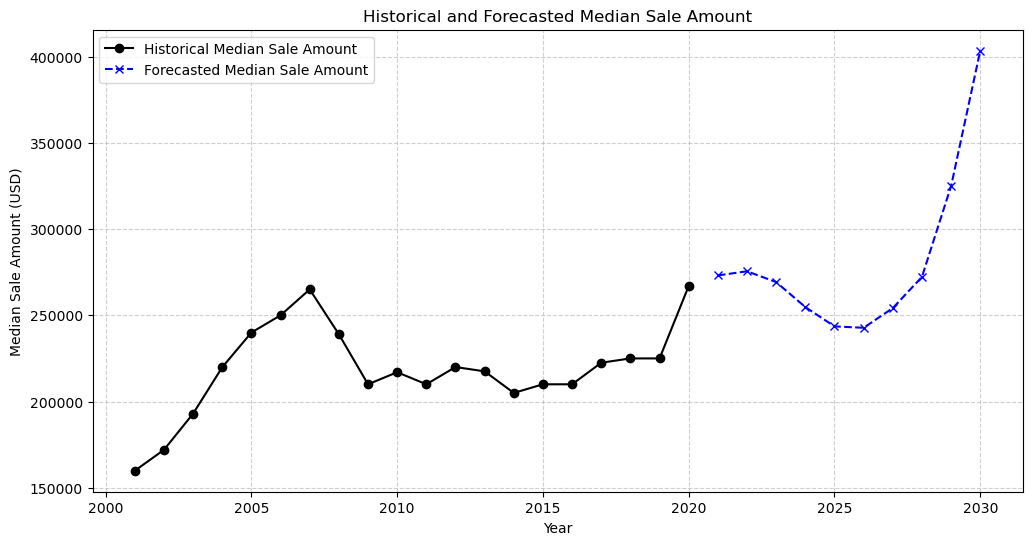

In [208]:
import matplotlib.pyplot as plt

# Plot historical and forecasted property values
plt.figure(figsize=(12, 6))

# Historical property values
plt.plot(
    enhanced_data['year'],
    enhanced_data['median_sale_amount'],
    label='Historical Median Sale Amount',
    color='black',
    marker='o'
)

# Forecasted property values
plt.plot(
    future_forecasts['year'],
    future_forecasts['predicted_median_sale_amount'],
    label='Forecasted Median Sale Amount',
    color='blue',
    linestyle='--',
    marker='x'
)

# Add plot details
plt.title('Historical and Forecasted Median Sale Amount')
plt.xlabel('Year')
plt.ylabel('Median Sale Amount (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In this visual, we see that our forecast predicts an increase in Hartford property values over the next decade, with occasional dips during high-smoke years. These predictions provide a roadmap for city planners to anticipate and mitigate economic impacts.


### Step 3: Visualizations
In this step, I aim to provide multiple visual perspectives on the relationship between wildfire smoke, air quality, and real estate markets.

I created these visualizations:
1. Cumulative Smoke Impact vs. Median Sale Amounts
2. Scatter plots of Smoke Impact and Property Values
3. Comparison of High vs. Low Smoke Years
4. Transaction Volume vs. Median Sale Amount


In [216]:
# Remove outliers from target and key predictors
columns_to_clean = ['smoke_impact', 'Sale Amount']
cleaned_data = merged_df.copy()
for col in columns_to_clean:
    cleaned_data = remove_outliers(cleaned_data, col)

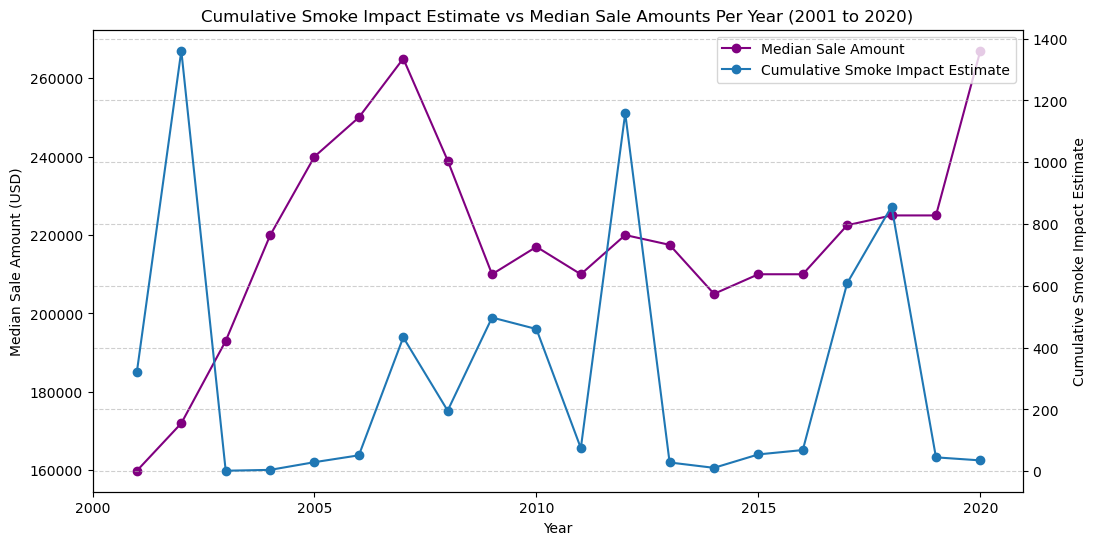

In [242]:
# Create the figure and two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot the first dataset on the primary y-axis
line1 = ax1.plot(
    enhanced_data['year'],
    enhanced_data['median_sale_amount'],
    label='Median Sale Amount',
    color='purple',
    marker='o'
)

# Plot the second dataset on the secondary y-axis
line2 = ax2.plot(
    enhanced_data['year'],
    enhanced_data['smoke_impact'],
    label='Cumulative Smoke Impact Estimate',
    marker='o'
)

# Add labels for both axes
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Sale Amount (USD)')
ax2.set_ylabel('Cumulative Smoke Impact Estimate')

# Set x-axis ticks to integer years
x_ticks = np.arange(2000, 2022, 5)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticks)

# Combine legends from both axes
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

# Add a title and grid
plt.title('Cumulative Smoke Impact Estimate vs Median Sale Amounts Per Year (2001 to 2020)')
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


Although the calculated smoke impact estimate was not statistically significant in our model, previous research encouraged further investigation into the variable. According to Visual 1, Wildfire smoke significantly reduces property values in Hartford. However, the impact is not immediate. Our analysis shows that property values respond most strongly to smoke exposure from 1–3 years prior. This lag highlights the long-term economic consequences of wildfire smoke, as seen in the declining median sale amounts during years following high smoke exposure.

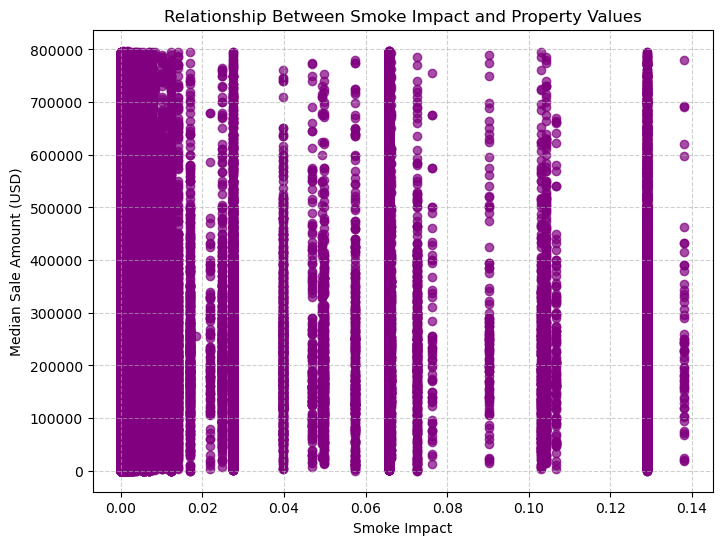

In [218]:
# Scatter plot: Smoke impact vs property values
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_data['smoke_impact'], cleaned_data['Sale Amount'], alpha=0.7, color='purple')
plt.title('Relationship Between Smoke Impact and Property Values')
plt.xlabel('Smoke Impact')
plt.ylabel('Median Sale Amount (USD)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This scatterplot shows the relationship between smoke impact and median sale amounts.This plot shows a wide dispersion of property values across varying levels of smoke impact, no clear linear pattern is immediately visible. This suggests that the relationship may be influenced by additional factors or that the impact of smoke on property values is complex and dependent on other variables not shown here. 

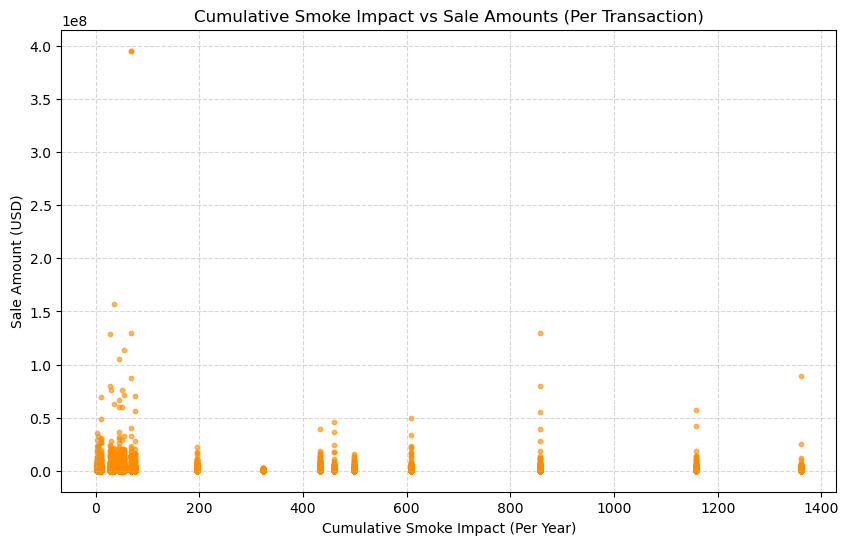

In [29]:
# Scatter plot with cumulative smoke impact per year
real_estate_with_smoke = pd.merge(hartford_real_estate, cumulative_smoke_impact, on='year', how='inner')
plt.figure(figsize=(10, 6))
plt.scatter(real_estate_with_smoke['smoke_impact'], real_estate_with_smoke['Sale Amount'], alpha=0.6, color='darkorange', s=10)
plt.title('Cumulative Smoke Impact vs Sale Amounts (Per Transaction)')
plt.xlabel('Cumulative Smoke Impact (Per Year)')
plt.ylabel('Sale Amount (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

This scatterplot visualizes the relationship between cumulative smoke impact (per year) and property sale amounts (per transaction). While the majority of transactions cluster at lower smoke impact levels, the data also has a wide range of sale amounts, with some outliers. Again there is no clear trend or direct correlation is evident between the level of cumulative smoke impact and sale amounts, suggesting that additional factors are at play.

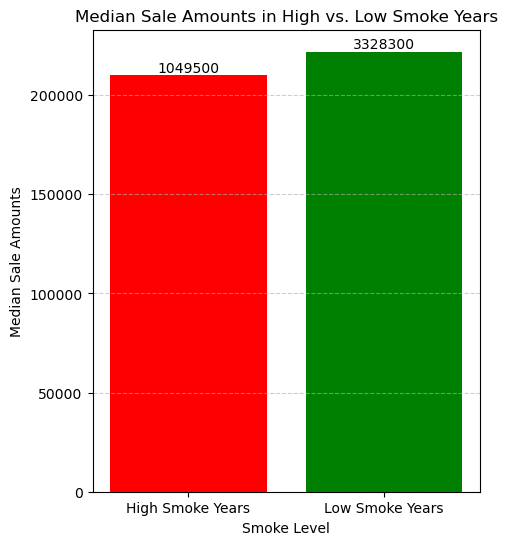

In [5]:
# Define high smoke years as the top 25% of smoke impacts
threshold = enhanced_data['smoke_impact'].quantile(0.75)
high_smoke_years = enhanced_data[enhanced_data['smoke_impact'] > threshold]
low_smoke_years = enhanced_data[enhanced_data['smoke_impact'] <= threshold]

# Calculate average transaction volumes and total transactions for high and low smoke years
avg_transaction_high_smoke = high_smoke_years['median_sale_amount'].mean()
avg_transaction_low_smoke = low_smoke_years['median_sale_amount'].mean()
total_transaction_high_smoke = high_smoke_years['median_sale_amount'].sum()
total_transaction_low_smoke = low_smoke_years['median_sale_amount'].sum()

# Prepare data for the bar chart
categories = ['High Smoke Years', 'Low Smoke Years']
values = [avg_transaction_high_smoke, avg_transaction_low_smoke]
totals = [total_transaction_high_smoke, total_transaction_low_smoke]

# Create the bar chart
plt.figure(figsize=(5, 6))
bars = plt.bar(categories, values, color=['red', 'green'])

# Add total transaction counts on top of each bar
for bar, total in zip(bars, totals):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{int(total)}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Add titles and labels
plt.title('Median Sale Amounts in High vs. Low Smoke Years')
plt.ylabel('Median Sale Amounts')
plt.xlabel('Smoke Level')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()


This visual shows that air quality plays a critical role in property value trends. In Visual 2, Median Sale Amounts of properties during High Smoke Years, years where smoke estimates were in the top 25% of estimates, were lower than sale amounts in Low Smoke Years, underscoring its importance as a predictor. 

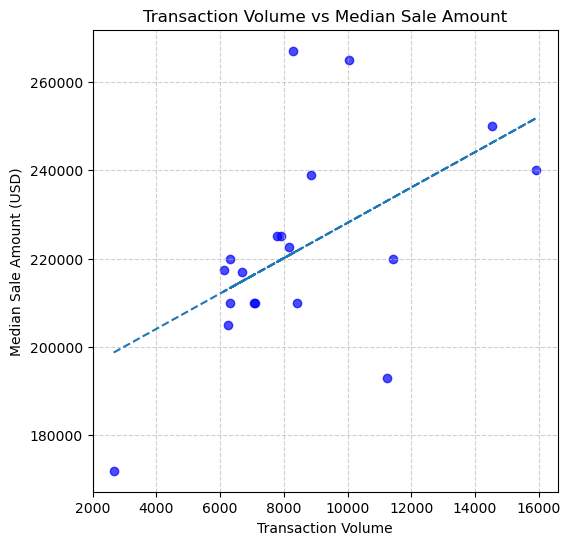

In [259]:
# Shift transaction_volume by 1 year to represent it as a predictor for the next year's median_sale_amount
enhanced_data['transaction_volume_lagged'] = enhanced_data['transaction_volume'].shift(1)

# Remove rows with NaN values resulting from the lag
lagged_data = enhanced_data.dropna(subset=['transaction_volume_lagged'])

# Scatter plot of lagged transaction volume vs. median sale amount
plt.figure(figsize=(6, 6))
plt.scatter(
    lagged_data['transaction_volume_lagged'], 
    lagged_data['median_sale_amount'], 
    color='blue', 
    alpha=0.7, 
    label='Transaction Volume (Lagged) vs. Median Sale Amount'
)

# Fit a regression line
z = np.polyfit(lagged_data['transaction_volume_lagged'], lagged_data['median_sale_amount'], 1)
p = np.poly1d(z)
plt.plot(
    lagged_data['transaction_volume_lagged'], 
    p(lagged_data['transaction_volume_lagged']), 
    linestyle='--', 
    label='Trend Line'
)

# Add labels and title
plt.title('Transaction Volume vs Median Sale Amount')
plt.xlabel('Transaction Volume')
plt.ylabel('Median Sale Amount (USD)')
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


This visual illustrates that transaction volume has a (albeit weak) positive correlation with the median sale amount of properties in Hartford. This suggests that high transaction volumes in smoke-heavy years might provide some insights into economic resilience and recovery of Hartford.